In [1]:
from keras.datasets import cifar10
import functools
import os
import tensorflow as tf

# Get variables and data ready

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
X_train_full.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
X_validation = X_train_full[-10_000:]
y_validation = y_train_full[-10_000:]
X_validation.shape, y_validation.shape

((10000, 32, 32, 3), (10000, 1))

In [5]:
X_train = X_train_full[:-10_000]
y_train = y_train_full[:-10_000]
X_train.shape, y_train.shape

((40000, 32, 32, 3), (40000, 1))

In [6]:
HEIGHT = 128
WIDTH = 128

# Plot some examples

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
import matplotlib.pyplot as plt

def plot_figures(X, y, n_rows=4, n_cols=10):
    plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols*row + col
            plt.subplot(n_rows, n_cols, index+1)
            plt.imshow(X[index])
            plt.title(class_names[y[index,0]])
            plt.axis('off')

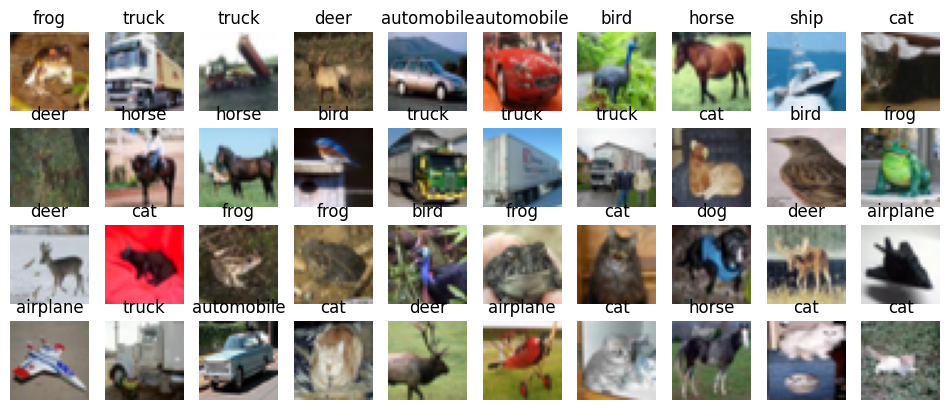

In [8]:
plot_figures(X_train, y_train)


# Create the inception module

In [24]:
DefaultConv = functools.partial(
    tf.keras.layers.Conv2D, kernel_size=(1, 1), strides=(1, 1),
    padding="same", activation="relu"
)

class InceptionModule(tf.keras.layers.Layer):
    def __init__(self, filters11, filters33_reduce, filters33, filters55_reduce, filters55, filters_pool_proj,
        use_batch_norm=True, ** kwargs):

        super().__init__( ** kwargs)
        self.conv11 = DefaultConv(filters=filters11)
        self.conv33_red = DefaultConv(filters=filters33_reduce)
        self.conv33 = DefaultConv(filters=filters33, kernel_size=(3, 3))
        self.conv55_red = DefaultConv(filters=filters55_reduce)
        self.conv55 = DefaultConv(filters=filters55, kernel_size=(5, 5))
        self.maxpool = tf.keras.layers.MaxPool2D(pool_size=3, padding='same', strides=1)
        self.filterspoolproj = DefaultConv(filters=filters_pool_proj)
        self.batch_norm = None
        if use_batch_norm:
            self.batch_norm = tf.keras.layers.BatchNormalization()

    def call(self, inputs):

        path1 = self.conv11(inputs)
        path2_1 = self.conv33_red(inputs)
        path2_2 = self.conv33(path2_1)
        path3_1 = self.conv55_red(inputs)
        path_3_2 = self.conv55(path3_1)
        path_4 = self.maxpool(inputs)
        path_4_1 = self.filterspoolproj(path_4)
        batch_norm_true = self.batch_norm(path_4_1)

        concat = tf.keras.layers.Concatenate(axis=-1)([path1, path2_2, path_3_2, path_4_1])

        if self.batch_norm:
            return tf.keras.layers.Concatenate(axis=-1)([path1, path2_2, path_3_2, path_4_1, batch_norm_true])
        return concat

# Test the first inception module from the GoogLeNet

In [10]:
test_inception = InceptionModule(filters11=64, filters33_reduce=96, filters33=128, filters55_reduce=16, filters55=32, filters_pool_proj=32, use_batch_norm=False)

In [11]:
test_arr = tf.constant(0.0, shape=(1, 16, 16, 192))

In [12]:
test_inception(test_arr).shape

TensorShape([1, 16, 16, 256])

# Implement the whole model

In [13]:
DefaultMaxPool = functools.partial(
    tf.keras.layers.MaxPool2D,pool_size=(3,3), strides=(2,2), padding='same')

DefaultConv = functools.partial(
    tf.keras.layers.Conv2D, kernel_size=(1, 1), strides=(1, 1),
    padding="same", activation="relu"
)

def get_googlenet_model(input_shape, num_classes, use_batch_norm=True, **kwargs):
  model = tf.keras.Sequential(**kwargs)
  model.add(DefaultConv(filters=64, kernel_size=(7, 7), strides=(2, 2), input_shape=input_shape))

  if use_batch_norm:
    model.add(tf.keras.layers.BatchNormalization())

  model.add(DefaultMaxPool())

  model.add(DefaultConv(filters=64))
  model.add(DefaultConv(filters=192, kernel_size=(3, 3)))

  if use_batch_norm:
    model.add(tf.keras.layers.BatchNormalization())

  model.add(DefaultMaxPool())

  model.add(InceptionModule(filters11=64, filters33_reduce=96, filters33=128, filters55_reduce=16, filters55=32, filters_pool_proj=32, use_batch_norm=use_batch_norm))
  model.add(InceptionModule(filters11=128, filters33_reduce=128, filters33=192, filters55_reduce=32, filters55=96, filters_pool_proj=64, use_batch_norm=use_batch_norm))

  model.add(DefaultMaxPool())

  model.add(InceptionModule(filters11=192, filters33_reduce=96, filters33=208, filters55_reduce=16, filters55=48, filters_pool_proj=64, use_batch_norm=use_batch_norm))
  model.add(InceptionModule(filters11=160, filters33_reduce=112, filters33=224, filters55_reduce=24, filters55=64, filters_pool_proj=64, use_batch_norm=use_batch_norm))
  model.add(InceptionModule(filters11=128, filters33_reduce=128, filters33=256, filters55_reduce=24, filters55=64, filters_pool_proj=64, use_batch_norm=use_batch_norm))
  model.add(InceptionModule(filters11=112, filters33_reduce=144, filters33=288, filters55_reduce=32, filters55=64, filters_pool_proj=64, use_batch_norm=use_batch_norm))
  model.add(InceptionModule(filters11=256, filters33_reduce=160, filters33=320, filters55_reduce=32, filters55=128, filters_pool_proj=128, use_batch_norm=use_batch_norm))

  model.add(DefaultMaxPool())

  model.add(InceptionModule(filters11=256, filters33_reduce=160, filters33=320, filters55_reduce=32, filters55=128, filters_pool_proj=128, use_batch_norm=use_batch_norm))
  model.add(InceptionModule(filters11=384, filters33_reduce=192, filters33=384, filters55_reduce=48, filters55=128, filters_pool_proj=128, use_batch_norm=use_batch_norm))

  model.add(tf.keras.layers.GlobalAveragePooling2D())

  model.add(tf.keras.layers.Dropout(rate=0.4))

  model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

  return model

In [14]:
preprocess_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(HEIGHT, WIDTH, input_shape=(32,32,3)),
    tf.keras.layers.Rescaling(scale=1/127.5, offset=-1)])

tf.keras.backend.clear_session()

model = get_googlenet_model(input_shape=(128,128,3), num_classes=10,use_batch_norm=False, name="GoogLeNet")
model.summary()

Model: "GoogLeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4160      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 192)       0         
 g2D)                                                            
                                                                 
 inception_module (Inceptio  (None, 16, 16, 256)       16

if the parameter "name" is not passed, the model will get the name "sequential" but the functionality would not be different

In [15]:
full_model = tf.keras.Sequential([preprocess_layer, model])

# Compile the model

In [16]:
full_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)

# Train the model

### One-hot-encode the labels

In [17]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_validation_one_hot = tf.keras.utils.to_categorical(y_validation, 10)

In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(restore_best_weights=True)
batch_size=128

history = full_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=batch_size, validation_data=(X_validation, y_validation_one_hot), callbacks=[early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 82s 166ms/step - loss: 1.9476 - accuracy: 0.2488 - val_loss: 1.5818 - val_accuracy: 0.3902
Epoch 2/100
313/313 [==============================] - 44s 141ms/step - loss: 1.4533 - accuracy: 0.4505 - val_loss: 1.2907 - val_accuracy: 0.5184
Epoch 3/100
313/313 [==============================] - 45s 143ms/step - loss: 1.1809 - accuracy: 0.5688 - val_loss: 1.0793 - val_accuracy: 0.6004
Epoch 4/100
313/313 [==============================] - 46s 148ms/step - loss: 0.9929 - accuracy: 0.6440 - val_loss: 0.9448 - val_accuracy: 0.6572
Epoch 5/100
313/313 [==============================] - 45s 142ms/step - loss: 0.8713 - accuracy: 0.6913 - val_loss: 0.8854 - val_accuracy: 0.6923
Epoch 6/100
313/313 [==============================] - 46s 148ms/step - loss: 0.7587 - accuracy: 0.7327 - val_loss: 0.7637 - val_accuracy: 0.7281
Epoch 7/100
313/313 [==============================] - 47s 149ms/step - loss: 0.6605 - accuracy: 0.7690 - val_loss: 0.7979 -

# Evaluate the model

In [19]:
import numpy as np

def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    for key, style in zip(history.history, ["r-o", "r-*", "b-o", "b-*"]):
        epochs = np.array(history.epoch)
        plt.plot(epochs + 1, history.history[key], style, label=key)
    plt.xlabel("Epoch")
    plt.axis([1, len(history.history['loss']), 0., 1])
    plt.legend(loc="lower left")
    plt.grid()

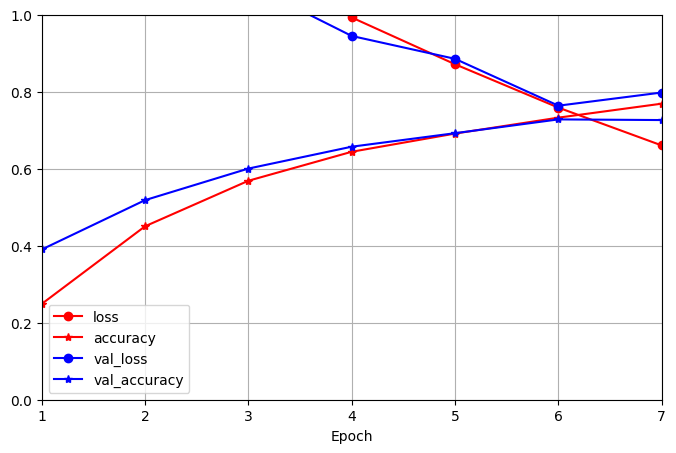

In [20]:
plot_learning_curves(history)

In [21]:
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

full_model.evaluate(X_test, y_test_one_hot)

313/313 [==============================] - 6s 13ms/step - loss: 0.7808 - accuracy: 0.7322


[0.7807925939559937, 0.732200026512146]

# Step 7: Improve the Model

In [25]:
preprocess_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(HEIGHT, WIDTH, input_shape=(32,32,3)),
    tf.keras.layers.Rescaling(scale=1/127.5, offset=-1)])

tf.keras.backend.clear_session()

model2 = get_googlenet_model(input_shape=(128,128,3), num_classes=10,use_batch_norm=True, name="GoogLeNet")
full_model2 = tf.keras.Sequential([preprocess_layer, model2])

In [26]:
full_model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [27]:
history2 = full_model2.fit(X_train, y_train_one_hot, epochs=100, batch_size=batch_size, validation_data=(X_validation, y_validation_one_hot), callbacks=[early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 82s 182ms/step - loss: 1.5854 - accuracy: 0.4167 - val_loss: 2.8938 - val_accuracy: 0.1652
Epoch 2/100
313/313 [==============================] - 54s 172ms/step - loss: 1.1529 - accuracy: 0.5851 - val_loss: 1.5545 - val_accuracy: 0.4854
Epoch 3/100
313/313 [==============================] - 53s 168ms/step - loss: 0.9262 - accuracy: 0.6709 - val_loss: 1.9667 - val_accuracy: 0.4421


In [28]:
full_model2.evaluate(X_test, y_test_one_hot)

313/313 [==============================] - 5s 15ms/step - loss: 1.5627 - accuracy: 0.4849


[1.5626693964004517, 0.48489999771118164]

### Adding data augmentation layer

In [36]:
data_augmentation = tf.keras.Sequential([
  tf.keras. layers. RandomFlip(mode="horizontal", seed=42),
  tf.keras. layers. RandomRotation(factor=0.05, seed=42),
  tf.keras. layers. RandomContrast(factor=0.2, seed=42)
])

In [44]:
full_model2_aug = tf.keras.Sequential([
    data_augmentation,
    full_model2
])

full_model2_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [45]:
full_model2_aug.fit(X_train, y_train_one_hot, epochs=100, batch_size=batch_size, validation_data=(X_validation, y_validation_one_hot), callbacks=[early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 80s 175ms/step - loss: 1.0852 - accuracy: 0.6148 - val_loss: 1.9852 - val_accuracy: 0.4676
Epoch 2/100
313/313 [==============================] - 51s 163ms/step - loss: 0.9276 - accuracy: 0.6762 - val_loss: 1.1878 - val_accuracy: 0.6201
Epoch 3/100
313/313 [==============================] - 51s 163ms/step - loss: 0.8276 - accuracy: 0.7123 - val_loss: 1.0060 - val_accuracy: 0.6703
Epoch 4/100
313/313 [==============================] - 53s 168ms/step - loss: 0.7605 - accuracy: 0.7353 - val_loss: 1.0530 - val_accuracy: 0.6606


In [ ]:
full_model2.evaluate(X_test, y_test_one_hot)

In [46]:
full_model2_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)

full_model2_aug.fit(X_train, y_train_one_hot, epochs=100, batch_size=batch_size, validation_data=(X_validation, y_validation_one_hot), callbacks=[early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 70s 167ms/step - loss: 0.6227 - accuracy: 0.7843 - val_loss: 0.6650 - val_accuracy: 0.7747
Epoch 2/100
313/313 [==============================] - 52s 165ms/step - loss: 0.5662 - accuracy: 0.8046 - val_loss: 0.5693 - val_accuracy: 0.8033
Epoch 3/100
313/313 [==============================] - 53s 169ms/step - loss: 0.5313 - accuracy: 0.8151 - val_loss: 0.5893 - val_accuracy: 0.8005


In [48]:
full_model2.evaluate(X_test, y_test_one_hot)

313/313 [==============================] - 5s 15ms/step - loss: 0.5742 - accuracy: 0.8065


[0.5742376446723938, 0.8065000176429749]

In [47]:
full_model2_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)

full_model2_aug.fit(X_train, y_train_one_hot, epochs=100, batch_size=batch_size, validation_data=(X_validation, y_validation_one_hot), callbacks=[early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 72s 167ms/step - loss: 0.5279 - accuracy: 0.8160 - val_loss: 0.5643 - val_accuracy: 0.8083
Epoch 2/100
313/313 [==============================] - 53s 168ms/step - loss: 0.5186 - accuracy: 0.8200 - val_loss: 0.5613 - val_accuracy: 0.8115
Epoch 3/100
313/313 [==============================] - 53s 169ms/step - loss: 0.5126 - accuracy: 0.8211 - val_loss: 0.5655 - val_accuracy: 0.8096


In [49]:
full_model2.evaluate(X_test, y_test_one_hot)

313/313 [==============================] - 5s 15ms/step - loss: 0.5742 - accuracy: 0.8065


[0.5742376446723938, 0.8065000176429749]